# Medical Cost - EDA and Regression Analysis

This notebook demonstrates a multiple linear regression workflow using the Medical Cost dataset from Kaggle. Each step is explained with markdown between code cells.

## Dataset Source
https://www.kaggle.com/datasets/mirichoi0218/insurance

In [129]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "insurance.csv"
# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path
) 

## Exploratory Data Analysis (EDA)

### Inspecting the Dataset

We begin by loading the dataset and inspecting its structure, including the first few rows and summary statistics.

In [130]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [132]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [133]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Separating Features and Target Variable

In [134]:
X = df.drop("charges", axis=1)
y = df["charges"]

### Identifying Categorical and Numerical Features

In [135]:
categorial_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Categorical Features:", categorial_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['sex', 'smoker', 'region']
Numerical Features: ['age', 'bmi', 'children']


In [136]:
df[categorial_features].nunique()

sex       2
smoker    2
region    4
dtype: int64

In [137]:
df[numerical_features].describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


### Data Visualization and Analysis

#### Visualizing Numerical Features


##### Distribution Plots
Distribution plots for numerical features to understand their distributions and identify any potential outliers.

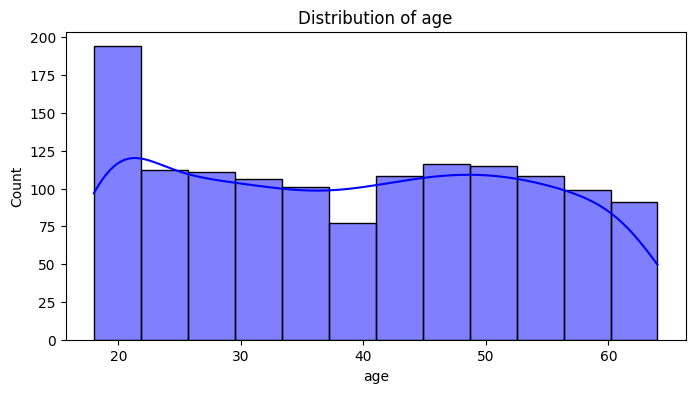

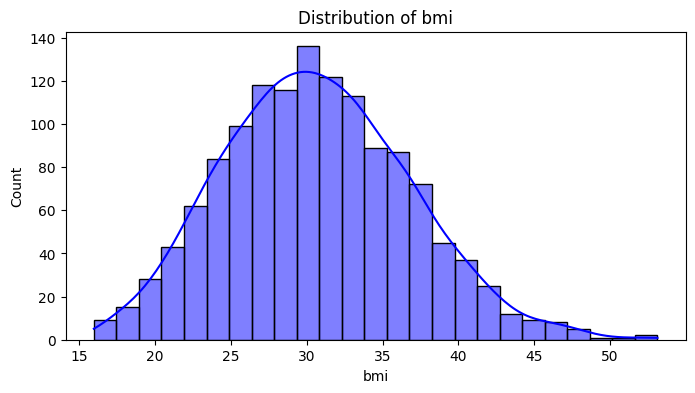

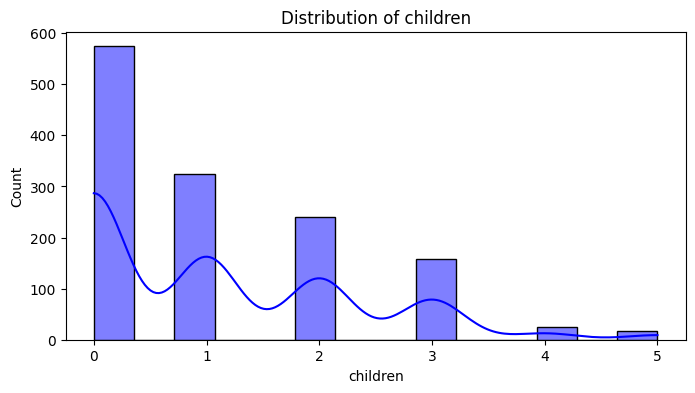

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    plt.show()

##### Scatter Plots
Scatter plots to visualize relationships between numerical features and the target variable (medical cost).

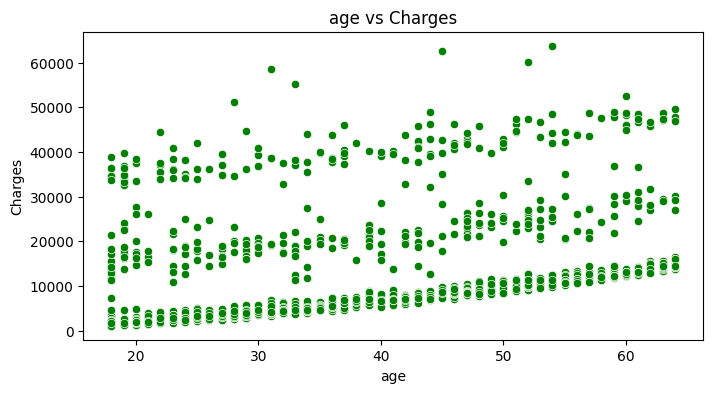

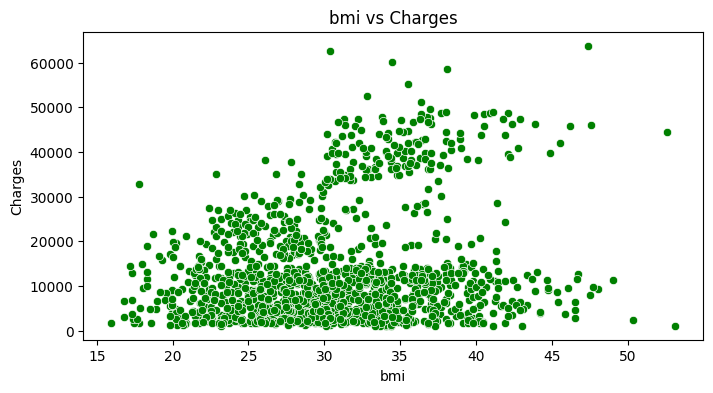

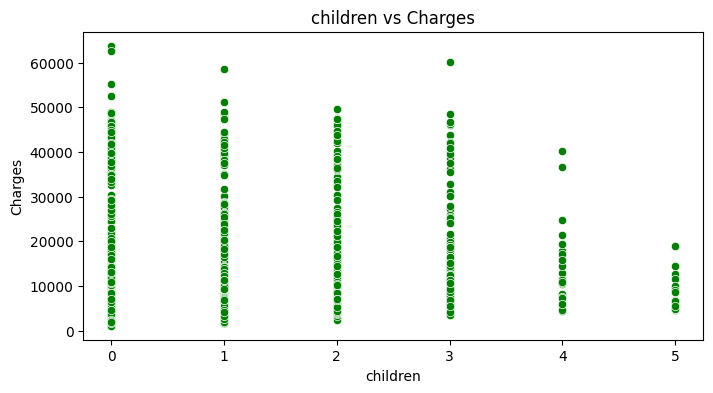

In [139]:
for col in df[numerical_features]:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df[col], y=df['charges'], color='green')
    plt.title(f'{col} vs Charges')
    plt.xlabel(col)
    plt.ylabel('Charges')
    plt.show()

##### Correlation Heatmap
Correlation heatmap to identify relationships between numerical features and the target variable.

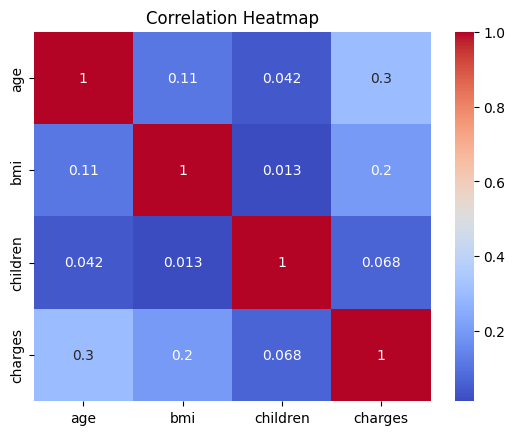

In [140]:
sns.heatmap(df[numerical_features + ['charges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Looks like top features are:
- age
- bmi
- children ~ 0 (We'll check if it can be dropped later)

##### Pair Plots
Pair plots to visualize pairwise relationships between numerical features and the target variable.

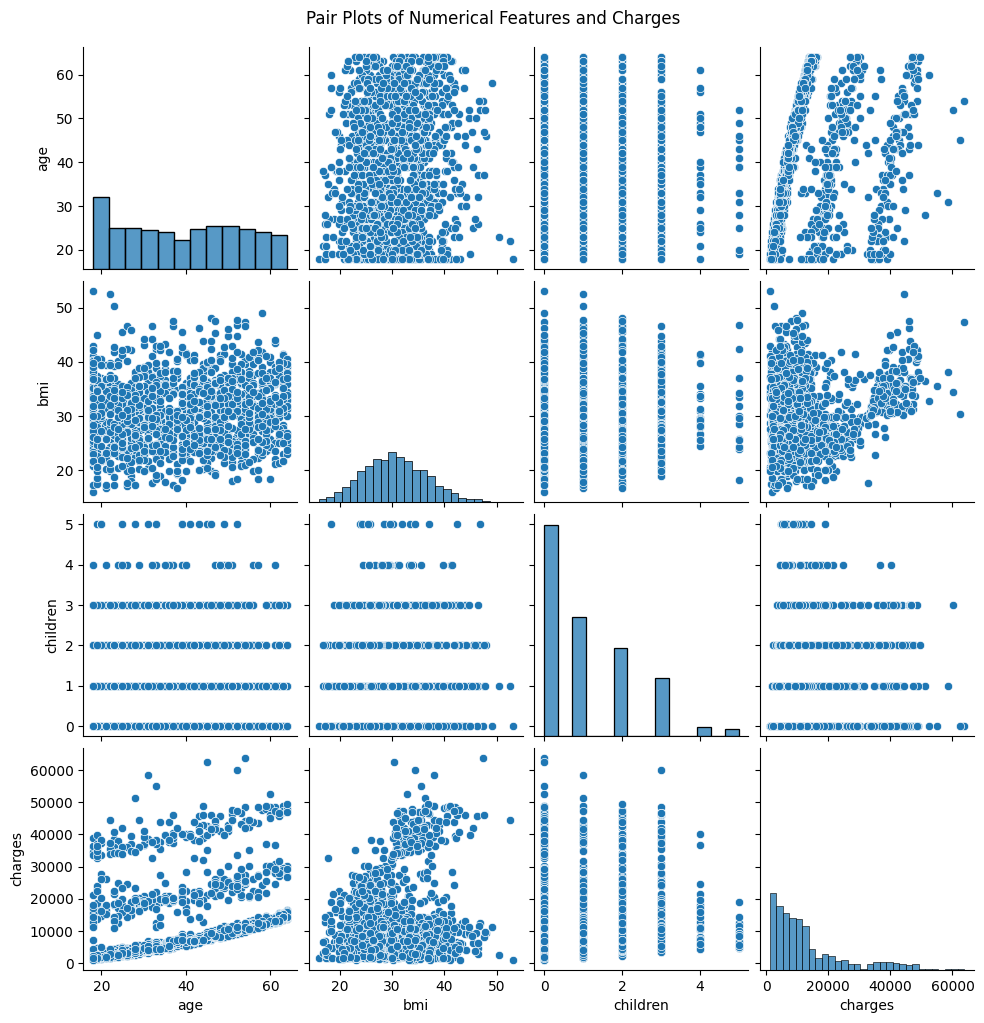

In [141]:
sns.pairplot(df, vars=numerical_features + ['charges'])
plt.suptitle('Pair Plots of Numerical Features and Charges', y=1.02)
plt.show()

##### Outlier Detection
Using box plots to identify outliers in numerical features.


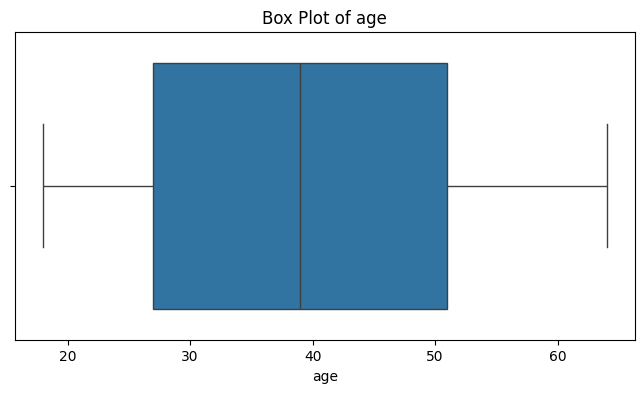

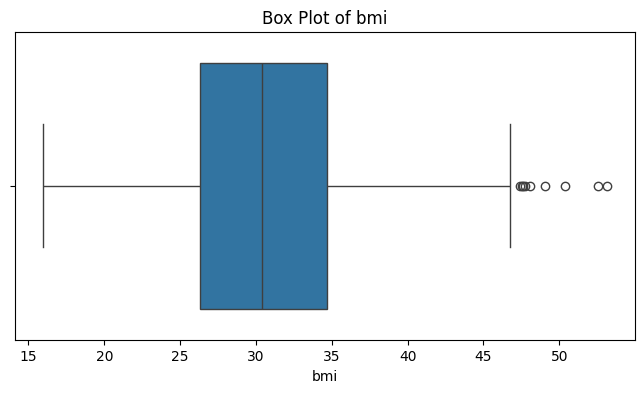

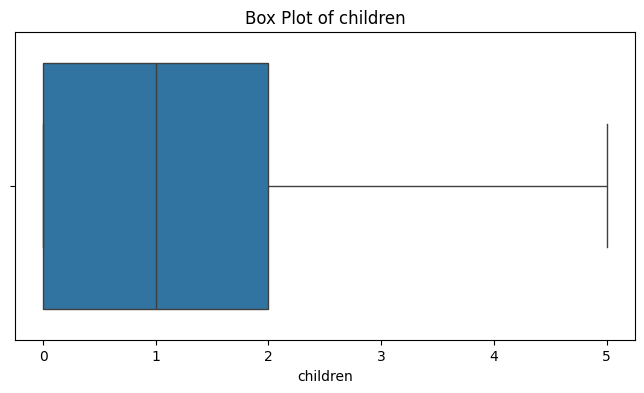

In [142]:
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

BMI has some outliers on the higher side which might affect the model. We'll consider handling them later.

#### Categorial Feature Analysis
Categorical feature analysis to understand the distribution of categorical variables and their impact on the target variable.

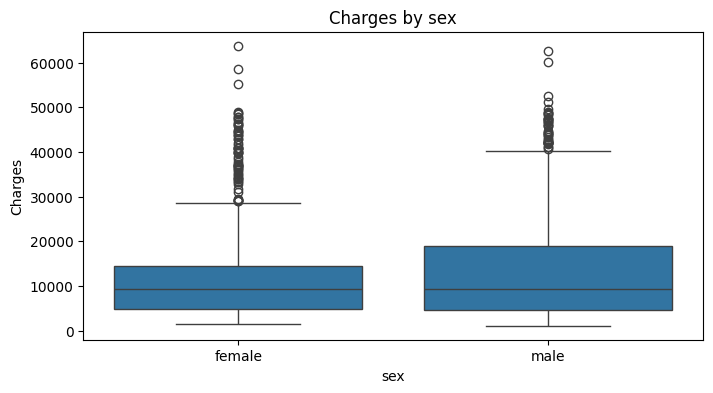

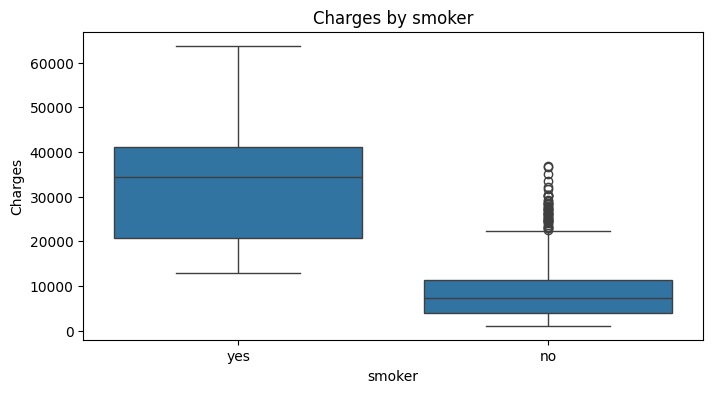

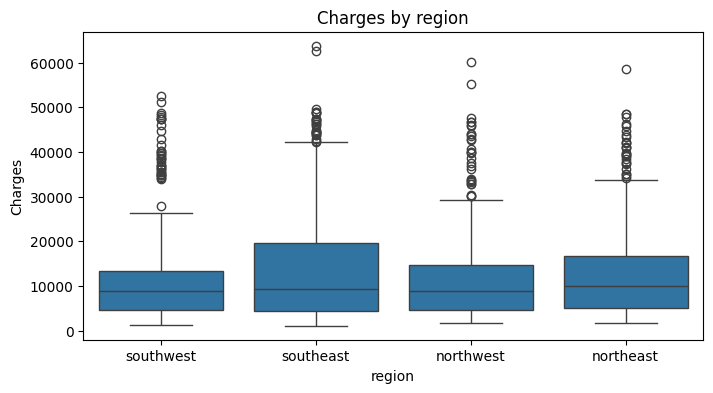

In [143]:
for col in df[categorial_features]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], y=df['charges'])
    plt.title(f'Charges by {col}')
    plt.xlabel(col)
    plt.ylabel('Charges')
    plt.show()

Looks like all categorial features have some impact on charges. We'll encode them and include them in the model.

- Gender: Males tend to have slightly higher charges, but have a lot of outliers as well.
- Smoker: Smokers have significantly higher charges, but have outliers when non-smokers have high charges as well.
- Region: Some regional differences in charges like southeast has higher charges compared to others, but have a lot of outliers as well.

##### Correlation Analysis between Smoker and BMI
Analyzing the correlation between being a smoker and BMI to see if there's any relationship that could affect the model.

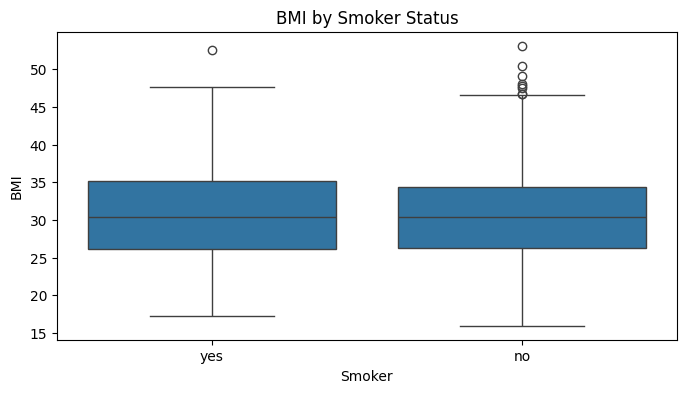

In [144]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['smoker'], y=df['bmi'])
plt.title('BMI by Smoker Status')
plt.xlabel('Smoker')
plt.ylabel('BMI')
plt.show()

Combining BMI and smoker and plotting boxplot to see if there's any correlation.

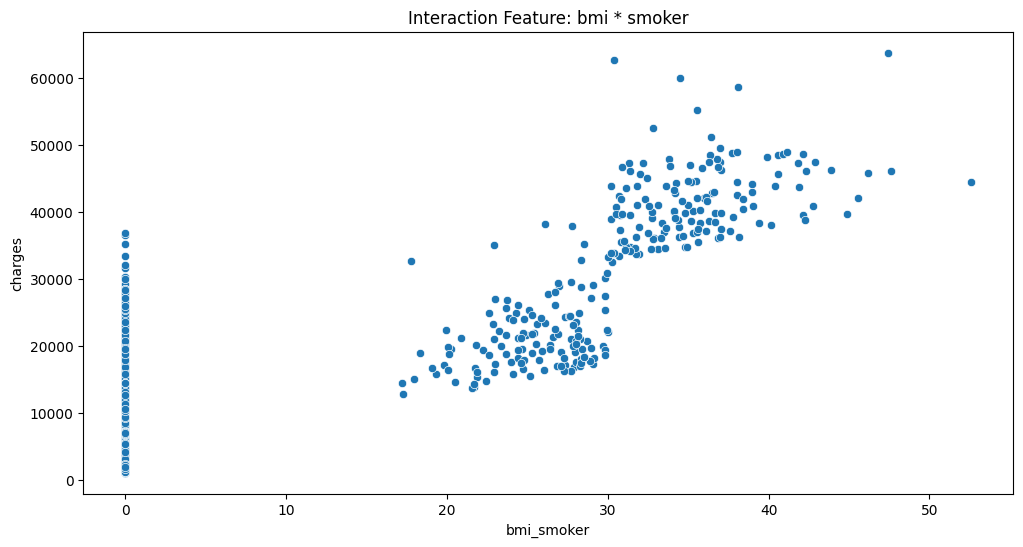

In [145]:
# combine BMI and smoker and plot boxplot to see if there's any correlation
df['bmi_smoker'] = df['bmi'] * (df['smoker'] == 'yes').astype(int)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='bmi_smoker', y='charges', data=df)
plt.title("Interaction Feature: bmi * smoker")
plt.show()


### Conclusions from EDA

- Numerical Features: 'age' and 'bmi' show strong correlations with medical costs. 'children' has a weak correlation and may be considered for removal.
- Categorical Features: 'smoker' has a significant impact on medical costs, while 'gender' and 'region' show moderate effects.


#### Combination Feature: bmi * smoker
Combining BMI and smoker has a strong correlation with charges when Smoker is 'yes'.

#### Feature Impact Summary

|Feature|Impact on Charges|
|-------|-----------------|
|age    |Moderate         |
|bmi    |Moderate         |
|children|Very Weak       |
|gender |Weak             |
|smoker |High             |
|region |Weak             |
|bmi * smoker |Very High    |


## Data Preprocessing
We will handle missing values, encode categorical variables, and scale numerical features as needed.

### Scaling and Encoding
We will use StandardScaler for numerical features and OneHotEncoder for categorical features.



In [147]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), 
         categorial_features)
    ],
    remainder='drop'
)



### Testing and Training Split
Splitting the dataset into training and testing sets to evaluate model performance.

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Applying Preprocessing
Applying the preprocessing steps to the training and testing data.

In [149]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model Training and Evaluation
Training a multiple linear regression model using the preprocessed training data.

### Linear Regression Model with all Features
Training a linear regression model using all features and evaluating its performance on the test set.

In [150]:
from sklearn.linear_model import LinearRegression
model_all = LinearRegression()
model_all.fit(X_train_processed, y_train)
y_pred_all = model_all.predict(X_test_processed)

In [151]:
from sklearn.metrics import mean_squared_error, r2_score
mse_all = mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)

print(f"Mean Squared Error (All Features): {mse_all:.2f}")
print(f"R^2 Score (All Features): {r2_all:.2f}")

Mean Squared Error (All Features): 33596915.85
R^2 Score (All Features): 0.78


Let us visualise the predictions vs actual charges.

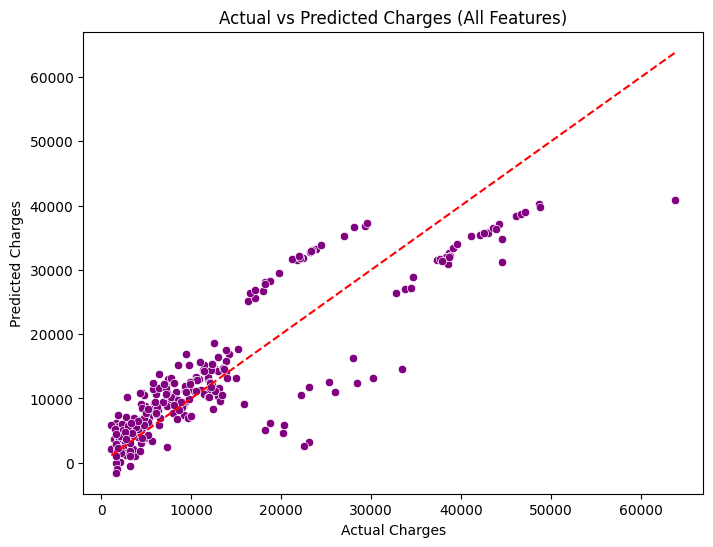

In [152]:
# visualize predictions vs actual charges
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_all, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (All Features)')
plt.show()

### Linear Regression model with reduced features
Training a linear regression model using only the most impactful features and evaluating its performance on the test set.

In [153]:
# remove children and region features and retrain the model
reduced_features = numerical_features.copy()
reduced_features.remove('children')
reduced_categorial_features = categorial_features.copy()
reduced_categorial_features.remove('region')

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), reduced_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), 
         reduced_categorial_features)
    ],
    remainder='drop'
)

X_train_reduced = preprocessor_reduced.fit_transform(X_train)
X_test_reduced = preprocessor_reduced.transform(X_test)
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = model_reduced.predict(X_test_reduced)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
r2_reduced = r2_score(y_test, y_pred_reduced)
print(f"Mean Squared Error (Reduced Features): {mse_reduced:.2f}")
print(f"R^2 Score (Reduced Features): {r2_reduced:.2f}")

Mean Squared Error (Reduced Features): 34515553.67
R^2 Score (Reduced Features): 0.78


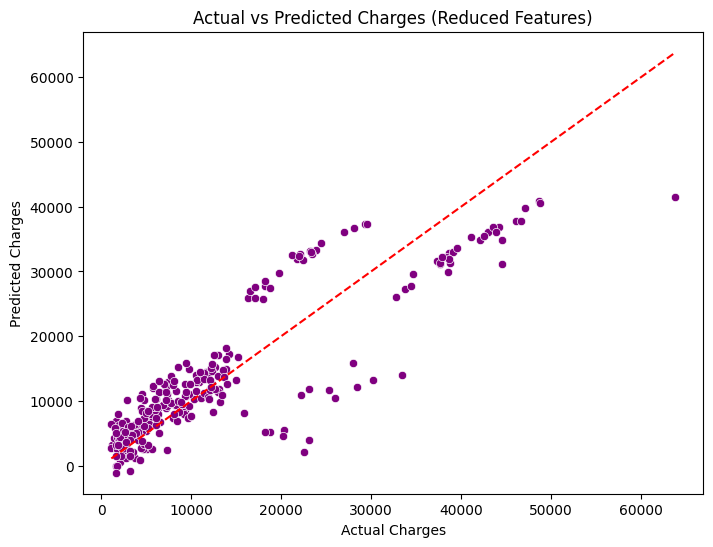

In [154]:
# visualize predictions vs actual charges for reduced model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_reduced, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Reduced Features)')
plt.show()

### Linear Regression Model with combined feature
Training a linear regression model using the combined feature (bmi * smoker) along with other impactful

In [161]:
X = df.drop("charges", axis=1)
y = df["charges"]

from sklearn.model_selection import train_test_split
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features + ['bmi_smoker']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), 
         categorial_features)
    ],
    remainder='drop'
)

X_train_combined_processed = preprocessor_combined.fit_transform(X_train_combined)
X_test_combined_processed = preprocessor_combined.transform(X_test_combined)

model_combined = LinearRegression()
model_combined.fit(X_train_combined_processed, y_train_combined)
y_pred_combined = model_combined.predict(X_test_combined_processed)
mse_combined = mean_squared_error(y_test_combined, y_pred_combined)
r2_combined = r2_score(y_test_combined, y_pred_combined)
print(f"Mean Squared Error (Combined Feature): {mse_combined:.2f}")
print(f"R^2 Score (Combined Feature): {r2_combined:.2f}")

Mean Squared Error (Combined Feature): 20919716.75
R^2 Score (Combined Feature): 0.87


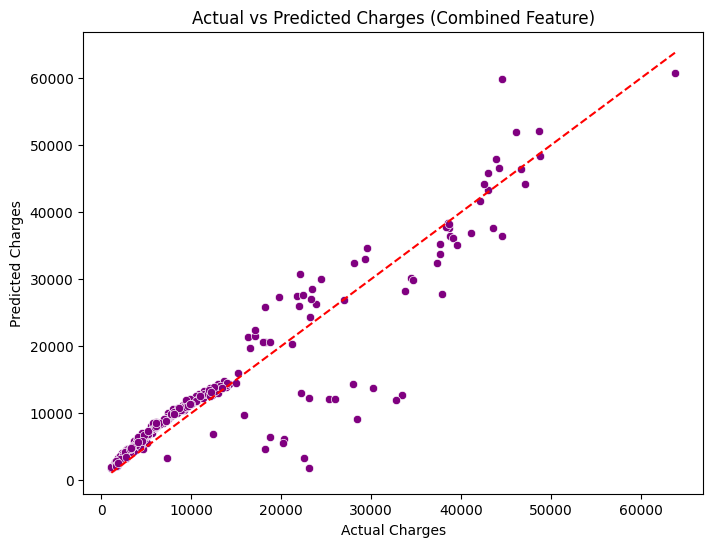

In [163]:
# visualize predictions vs actual charges for combined feature model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_combined, y=y_pred_combined, color='purple')
plt.plot([y_test_combined.min(), y_test_combined.max()], [y_test_combined.min(), y_test_combined.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges (Combined Feature)')
plt.show()

This fits much better than previous models.

### Applying Ridge Regression
Training a Ridge regression model to see if it improves performance over linear regression with combined feature.

In [165]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_combined_processed, y_train_combined)
y_pred_ridge = ridge_model.predict(X_test_combined_processed)
mse_ridge = mean_squared_error(y_test_combined, y_pred_ridge)
r2_ridge = r2_score(y_test_combined, y_pred_ridge)
print(f"Mean Squared Error (Ridge Regression): {mse_ridge:.2f}")
print(f"R^2 Score (Ridge Regression): {r2_ridge:.2f}")  

Mean Squared Error (Ridge Regression): 20820859.75
R^2 Score (Ridge Regression): 0.87


No improvement with Ridge Regression in this case.pact observed with standard linear regression.

#### Applying Lasso Regression
Training a Lasso regression model to see if it improves performance over standard linear regression.

In [166]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_combined_processed, y_train_combined)
y_pred_lasso = lasso_model.predict(X_test_combined_processed)
mse_lasso = mean_squared_error(y_test_combined, y_pred_lasso)
r2_lasso = r2_score(y_test_combined, y_pred_lasso)
print(f"Mean Squared Error (Lasso Regression): {mse_lasso:.2f}")
print(f"R^2 Score (Lasso Regression): {r2_lasso:.2f}")

Mean Squared Error (Lasso Regression): 20918775.59
R^2 Score (Lasso Regression): 0.87


## Conclusions
- The multiple linear regression model performed reasonably well in predicting medical costs, with an R^2 score indicating a good fit.
- Key features influencing medical costs were identified, with 'smoker' status and 'bmi * smoker' combination having the highest impact.
- Adding this combined feature significantly improved model performance.
- In reality there was no significant improvement observed with regularization techniques like Ridge and Lasso regression compared to standard linear regression in this case.